In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import umap
import fastcluster  
from sklearn.preprocessing import StandardScaler
import polars as pl
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.model_selection import train_test_split

## Supervised approach for POD determination

In [ ]:
## We take the dmso and jump controls as training set , we exclude the empty (untreated) wells
## We take 10 dmso wells + the compounds( 27) at differnet concentrations as prediction set

norm_data = pl.read_parquet("../00.exploratory_analysis/CP_data/normalized.parquet")
norm_data = norm_data.to_pandas()

norm_data = norm_data[norm_data['Metadata_BROAD_ID'] != 'EMPTY']
norm_data.loc[norm_data['Metadata_BROAD_ID'] == 'DMSO', 'Metadata_Compound Name'] = 'DMSO'
norm_data.loc[norm_data['Metadata_BROAD_ID'] == 'DMSO', 'Metadata_Annotation'] = 'DMSO'

#norm_data.loc[norm_data['Metadata_BROAD_ID'] == 'EMPTY', 'Metadata_Compound Name'] = 'no treatment'
#norm_data.loc[norm_data['Metadata_BROAD_ID'] == 'EMPTY', 'Metadata_Annotation'] = 'no treatment'

We use a Random Forest classifier to distinguish treated cells from DMSO controls at various concentrations for each compound. By training the model at each concentration, we measure how well the treatment effect could be detected (via AUC) and identify the lowest concentration at which the compound begins to show a significant deviation from DMSO, serving as an estimate of the Point of Departure (POD).

In [ ]:

compound_col = "Metadata_Compound Name"
category = "Metadata_Annotation"
concentration_col = "Metadata_assay_conc_uM"
feat_data = norm_data.drop(columns=[col for col in norm_data.columns if col.startswith("Metadata")])
features = feat_data.columns
results = {}


df_dmso = norm_data[norm_data[concentration_col] == 0]


df_jump_control = norm_data[norm_data[category] == "JUMP control"]

df_nt = norm_data[norm_data[category] == "no treatment"]


df_dmso_filt = df_dmso.drop(columns=[col for col in df_dmso.columns if col.startswith("Metadata")])
df_jump_control_filt = df_jump_control.drop(columns=[col for col in df_jump_control.columns if col.startswith("Metadata")])
df_nt_filt = df_nt.drop(columns=[col for col in df_nt.columns if col.startswith("Metadata")])

df_dmso_train= df_dmso_filt[10:64]

df_dmso_train["label"] = 0
df_nt_filt["label"] = 0
df_jump_control_filt["label"] = 1


df_train = pd.concat([df_dmso_train, df_jump_control_filt, df_nt_filt])

X_train = df_train[features].values
y_train = df_train["label"].values


clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


df_controls_pos = norm_data[norm_data[category] != "JUMP control"]
df_controls_pos = df_controls_pos[df_controls_pos[category] != "DMSO"]
#df_controls_pos = df_controls_pos[df_controls_pos[category] != "no treatment"]
#df_controls_neg = norm_data[norm_data[concentration_col] == 0].copy()

df_dmso_10 = df_dmso[0:10]

df_pred = pd.concat([df_controls_pos, df_dmso_10])


df_pred_filt= df_pred.drop(columns=[col for col in df_pred.columns if col.startswith("Metadata")])


X_pred = df_pred_filt[features].values


y_pred_proba = clf.predict_proba(X_pred)[:,1]

df_pred['Probability'] = y_pred_proba

print(df_pred)


In [5]:
df_pred.to_csv("/Users/grigoryanmariam/newproject/2025_Grigoryan_Proteomics/01.dose_response/outputs/df_pred.csv", index=False)

## Model Based Clustering applied to well level CP data

In [ ]:

from scipy.stats import multivariate_normal


def initialize_parameters(X, K):
   np.random.seed(42)
   n_samples, n_features = X.shape
   mu = X[np.random.choice(n_samples, K, replace=False)]
   pi = np.ones(K) / K
   Sigma = np.array([np.eye(n_features) for _ in range(K)])

   return mu, Sigma, pi



#pour éviter les matrices singulières 
def regularize_covariance(cov, epsilon=1e-4):
    return cov + np.eye(cov.shape[0]) * epsilon
  

def e_step(X, mu, Sigma, pi):
    n_samples, n_features = X.shape
    K = len(pi)
    log_alpha = np.zeros((n_samples, K))
    
    for k in range(K):
        cov_matrix = regularize_covariance(Sigma[k])
        
        rv = multivariate_normal(mean=mu[k], cov=cov_matrix)
        
        log_pdf_values = rv.logpdf(X)
        
        log_alpha[:, k] = np.log(pi[k]) + log_pdf_values

    log_alpha_max = np.max(log_alpha, axis=1, keepdims=True)
    log_alpha -= log_alpha_max
    alpha = np.exp(log_alpha)
    
    alpha_sum = alpha.sum(axis=1)[:, np.newaxis]
    alpha_sum = np.maximum(alpha_sum, 1e-10)
    alpha /= alpha_sum

    if np.any(np.isnan(alpha)) or np.any(np.isinf(alpha)):
        raise ValueError("Alpha contains invalid values.")
    
    return alpha





def m_step(X, alpha):
    n_samples, n_features = X.shape
    K = alpha.shape[1]
    Nk = alpha.sum(axis=0)

    pi = Nk / n_samples
    pi = np.maximum(pi, 1e-10)
    pi /= np.sum(pi)

    mu = np.dot(alpha.T, X) / Nk[:, np.newaxis]

    Sigma = np.zeros((K, n_features, n_features))

    for k in range(K):
        diff = X - mu[k]
        poids = alpha[:, k][:, np.newaxis] * diff
        poids = np.dot(poids.T, diff)
        diag_covariance = np.diag(poids) / Nk[k]
        Sigma[k] = np.diag(diag_covariance)
        
        # Vérification de la matrice de covariance
        if np.any(np.isnan(Sigma[k])) or np.any(np.isinf(Sigma[k])):
            print(f"Invalid values in covariance matrix for cluster {k}")
    
    return mu, Sigma, pi


def log_likelihood(X, mu, Sigma, pi):
    n_samples = X.shape[0]
    n_clusters = len(pi)
    densities = []

    for k in range(n_clusters):
        try:
            densities.append(multivariate_normal.pdf(X, mean=mu[k], cov=Sigma[k]))
        except np.linalg.LinAlgError:
           
            Sigma[k] += np.eye(len(Sigma[k])) #* 1e-6  # Small regularization
            densities.append(multivariate_normal.pdf(X, mean=mu[k], cov=Sigma[k]))

    densities = np.array(densities).T
    weighted_densities = densities * pi
    ll = np.sum(np.log(np.sum(weighted_densities, axis=1) + 1e-10))

    return ll




def log_likelihood_complete(X, mu, Sigma, pi, alpha):
    log_densities = np.array([multivariate_normal.logpdf(X, mean=mu[k], cov=Sigma[k]) for k in range(len(pi))]).T
    weighted_log_densities = alpha * (np.log(pi) + log_densities)
    ll_comp = np.sum(weighted_log_densities)
    return ll_comp





## EM sans les critères
def em_algorithm(X, K, max_iter=100, tol=1e-4):
    mu, Sigma, pi = initialize_parameters(X, K)
    log_likelihoods = []

    for iteration in range(max_iter):
        alpha = e_step(X, mu, Sigma, pi)
        mu, Sigma, pi = m_step(X, alpha)
        ll = log_likelihood_complete(X, mu, Sigma, pi, alpha)  
        log_likelihoods.append(ll)


        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    return mu, Sigma, pi, alpha



np.random.seed(42)



In [ ]:


def find_best_initialization(X_ref, K, n_init=10, max_iter=100, tol=1e-6):
    best_ll_complete = -np.inf
    best_params = None
    for init in range(n_init):
        try:
            mu, Sigma, pi = initialize_parameters(X_ref, K)
            mu_est, Sigma_est, pi_est, alpha_est = em_algorithm(
                X_ref, K, max_iter=max_iter, tol=tol
            )
            ll_complete = log_likelihood_complete(X_ref, mu_est, Sigma_est, pi_est, alpha_est)
            if ll_complete > best_ll_complete:
                best_ll_complete = ll_complete
                best_params = {"mu": mu_est, "Sigma": Sigma_est, "pi": pi_est}
        except Exception as e:
            print(f"Initialization {init + 1}/{n_init} failed: {e}")
    if best_params is None:
        raise ValueError("No valid initialization was found.")
    return best_params





def compute_bic(X, num_param, log_likelihood):
    n_samples = X.shape[0]
    return (-2) * log_likelihood + np.log(n_samples) * num_param

def compute_aic(log_likelihood, num_param):
    return -2 * log_likelihood + 2 * num_param



def compute_icl(X, num_param, log_likelihood_comp):
    n_samples = X.shape[0]
    return (-2) * log_likelihood_comp + np.log(n_samples) * num_param



# Algorithme EM avec calcule des critères 
def em_algorithm_crit(X, K, n_well, max_iter=100, tol=1e-6):
    try:
        best_params = find_best_initialization(X, K)
    except ValueError as e:
        print(e)
        return None, None, None, None
    
    mu, Sigma, pi = best_params["mu"], best_params["Sigma"], best_params["pi"]
    n_samples, n_features = X.shape
    log_likelihoods = []

    for iteration in range(max_iter):
        alpha = e_step(X, mu, Sigma, pi)  
        mu, Sigma, pi = m_step(X, alpha)  
        
        ll = log_likelihood(X, mu, Sigma, pi)  # Log-vraisemblance simple
        ll_comp = log_likelihood_complete(X, mu, Sigma, pi, alpha) # Log-vraisemblance complète
        
        log_likelihoods.append(ll)
        
        if iteration > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break

    # Calcul des critères
    num_param = 2*K * n_features + (K-1)*n_well
    icl = compute_icl(X, num_param, ll_comp)

    print(f"K={K}, Log-likelihood={ll:.2f}, Log-likelihood Complete={ll_comp:.2f}, Num Params={num_param}, ICL={icl:.2f}")

    return mu, Sigma, pi, alpha, icl



n_well= norm_data['Metadata_Well'].nunique()

K_values = range(2, 7)
icl_scores = []


for K in K_values:
    _, _, _, _, icl = em_algorithm_crit(scaled, K, n_well)
    icl_scores.append(icl)


optimal_K_icl = K_values[np.argmin(icl_scores)]

print(f"Optimal K based on ICL: {optimal_K_icl}")



In [ ]:
## optimal number of clusters K= 6 but I did 4 bc we see much better the separation of the clusters

mu, Sigma, pi, alpha = em_algorithm(scaled,4)
print("Means:", mu)
print("Covariances:", Sigma)
print("Proportions:", pi)

Means: [[ 0.35646338 -0.27027968  0.50717175 ... -0.44154172  0.50421772
   0.02269905]
 [-0.50544962  0.18729155 -0.28993879 ...  0.23530269 -0.30510769
  -0.06699984]
 [ 0.30780729  0.28222394 -0.7933641  ... -0.07856226  0.74672302
   0.42902729]
 [ 0.25920331 -0.20903722  0.46304318 ...  0.12995478 -0.51887602
  -0.19420224]]
Covariances: [[[0.45204458 0.         0.         ... 0.         0.         0.        ]
  [0.         0.81087432 0.         ... 0.         0.         0.        ]
  [0.         0.         0.4573777  ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.71078879 0.         0.        ]
  [0.         0.         0.         ... 0.         0.40238939 0.        ]
  [0.         0.         0.         ... 0.         0.         0.10556194]]

 [[0.37616478 0.         0.         ... 0.         0.         0.        ]
  [0.         0.99274856 0.         ... 0.         0.         0.        ]
  [0.         0.         0.35657819 ... 0.         0.  

In [ ]:
cluster_assignments = np.argmax(alpha, axis=1)

df = pd.DataFrame({
    'Cluster': cluster_assignments,
    'Name': norm_data['Metadata_Compound Name'],
    'Well' : norm_data['Metadata_Well'],
    'Plate' : norm_data['Metadata_Plate'],
    'Concentration': norm_data['Metadata_assay_conc_uM'],
    'Category': norm_data['Metadata_Annotation']
})

cluster_freq = df.groupby(['Well', 'Concentration', 'Name', 'Plate'])['Cluster'].value_counts(normalize=True).unstack(fill_value=0)


Do a graph of each cluster showing the names and the concentration of compound in that cluster  x per plate

In [ ]:
print(df)

     Cluster         Name Well       Plate  Concentration      Category
0          3      AMG 900  E03  BR00145692            5.1  JUMP control
1          3         DMSO  A17  BR00145692            0.0          DMSO
22         1      AMG 900  F22  BR00145692            5.1  JUMP control
23         0         DMSO  A20  BR00145692            0.0          DMSO
24         0      AMG 900  G15  BR00145692            5.1  JUMP control
..       ...          ...  ...         ...            ...           ...
743        3         DMSO  P01  BR00145695            0.0          DMSO
744        0  Aloxistatin  F17  BR00145695            5.1  JUMP control
745        0         DMSO  H07  BR00145695            0.0          DMSO
766        3  Aloxistatin  N24  BR00145695            5.1  JUMP control
767        3         DMSO  P16  BR00145695            0.0          DMSO

[688 rows x 6 columns]


In [ ]:
summary

Category,DMSO,JUMP control,negative control,positive control,total,pct_DMSO,pct_JC,pct_PC,pct_NC
Cluster,,,,,,,,,
0,27,25,61,54,167,0.161677,0.149701,0.323353,0.365269
1,21,35,88,117,261,0.080460,0.134100,0.448276,0.337165
2,2,3,21,77,103,0.019417,0.029126,0.747573,0.203883
3,14,21,50,72,157,0.089172,0.133758,0.458599,0.318471


In [ ]:
tableau = df[['Cluster', 'Name', 'Concentration', 'Category', 'Plate']].sort_values(by='Cluster')
print(tableau)

     Cluster                       Name  Concentration Category       Plate
383        0                       DMSO        0.00000     DMSO  BR00145692
265        0                       DMSO        0.00000     DMSO  BR00145692
266        0   Nedocromil (sodium salt)       75.00000       NC  BR00145692
269        0   Nedocromil (sodium salt)        2.77780       NC  BR00145692
270        0   Nedocromil (sodium salt)        0.92593       NC  BR00145692
..       ...                        ...            ...      ...         ...
495        3                  Bevirimat       11.11100       NC  BR00145695
496        3                  Bevirimat        3.70370       NC  BR00145695
497        3                  Bevirimat        1.23460       NC  BR00145695
305        3  Aminodarone Hydrochloride        0.15432       PC  BR00145692
767        3                       DMSO        0.00000     DMSO  BR00145695

[688 rows x 5 columns]


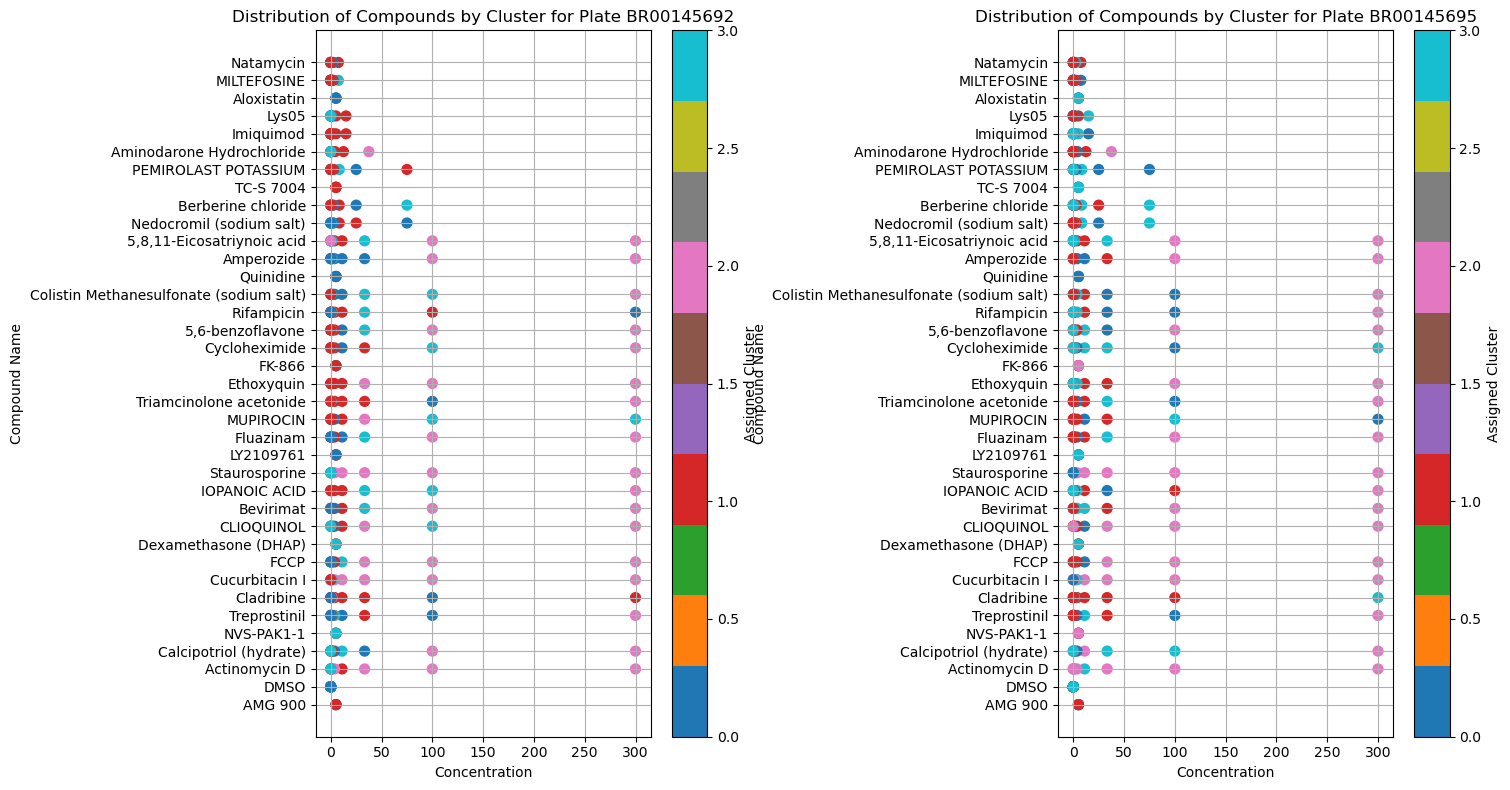

In [ ]:
## plot the distribution of the clusters per plate

fig, ax = plt.subplots(1, 2, figsize=(15, 8))

plates = df['Plate'].unique()

for i, plate in enumerate(plates):
    df_plate = df[df['Plate'] == plate]
    scatter = ax[i].scatter(df_plate['Concentration'], df_plate['Name'], 
                             c=df_plate['Cluster'], cmap='tab10', s=50)
    ax[i].set_xlabel("Concentration")
    ax[i].set_ylabel("Compound Name")
    ax[i].set_title(f"Distribution of Compounds by Cluster for Plate {plate}")
    ax[i].grid(True)
    fig.colorbar(scatter, ax=ax[i], label="Assigned Cluster")

plt.tight_layout()
plt.show()


We calculate the number of DMSO wells for each cluster and plate. They are mostly found in clusters 1 and 2. In the heatmap results, we can clearly observe that for the first plate, clusters 1, 2, and 4 consist of DMSO wells + compounds at concentrations up to 100 µM, except for Mupirocin, which is at 200 µM. For cluster 2, the majority are compounds at high concentrations (starting from 75 µM), positive controls known to induce a phenotypic effect in HepaRG cells and negative controls where we could say the effects are more evident at higher concentrations. For the second plate, the same trends apply with the majority of DMSO wells in clusters 1 and 2. The trends for the other compounds are also similar.

In [ ]:
# number of wells DMSO per cluster and per plate
dmso_df = tableau[tableau['Name'] == 'DMSO']

dmso_count = dmso_df.groupby(['Cluster', 'Plate', 'Concentration']).size().reset_index(name='DMSO Count')

print(dmso_count)


   Cluster       Plate  Concentration  DMSO Count
0        0  BR00145692            0.0          15
1        0  BR00145695            0.0          12
2        1  BR00145692            0.0           8
3        1  BR00145695            0.0          13
4        2  BR00145695            0.0           2
5        3  BR00145692            0.0           9
6        3  BR00145695            0.0           5


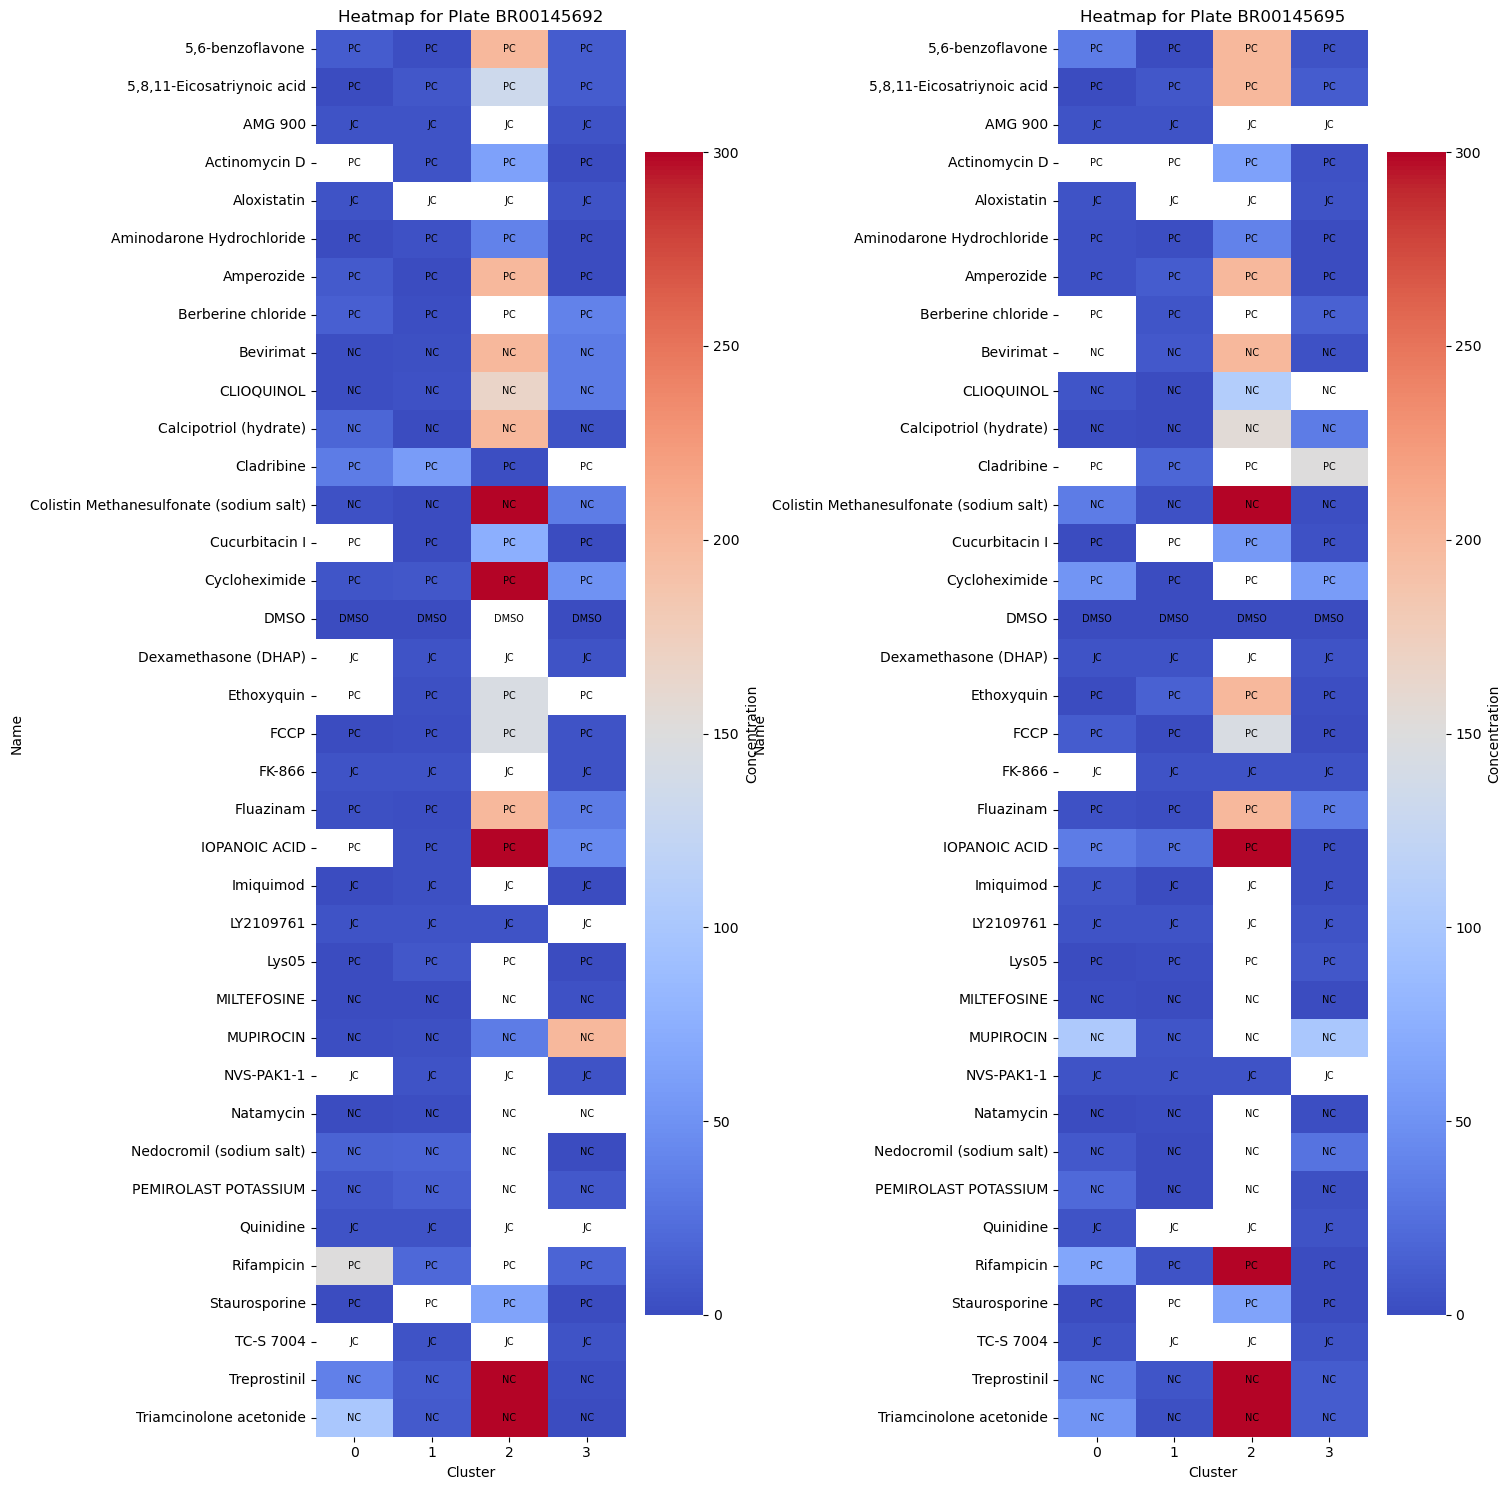

In [ ]:
## heatmap of the clusters per plate

plates = df['Plate'].unique()

df['Category'] = df['Category'].replace({'positive control': 'PC', 'negative control': 'NC', 'JUMP control': 'JC'})

fig, ax = plt.subplots(1, len(plates), figsize=(15,15))

for i, plate in enumerate(plates):
    df_plate = df[df['Plate'] == plate]
    heatmap_data = df_plate.pivot_table(index='Name', columns='Cluster', values='Concentration')
    categories = df_plate.groupby('Name')['Category'].first()

    ax[i].set_title(f"Heatmap for Plate {plate}")
    sns.heatmap(heatmap_data, cmap='coolwarm', cbar_kws={'label': 'Concentration'}, annot=False, ax=ax[i])

    for j in range(len(heatmap_data.index)):
        for k in range(len(heatmap_data.columns)):
            ax[i].text(k + 0.5, j + 0.5, categories[heatmap_data.index[j]], ha='center', va='center', color='black', fontsize=7)

    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=0)
    ax[i].set_yticklabels(ax[i].get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()



We analyze the distribution of wells across clusters by compound category (DMSO, positive control, etc.). Clusters enriched in positive controls are annotated as 'phenotype-altered'. Then, for each tested compound, the POD was defined as the lowest concentration at which its wells were assigned predominantly to an altered cluster. We extract the first concentration for each compound where more than 50% of its wells are assigned to the "altered" cluster.

In [ ]:
## POD determination 

summary = df.groupby(['Cluster', 'Category']).size().unstack(fill_value=0)
summary['total'] = summary.sum(axis=1)
summary['pct_DMSO'] = summary.get('DMSO', 0) / summary['total']
summary['pct_JC'] = summary.get('JUMP control', 0) / summary['total']
summary['pct_PC'] = summary.get('positive control', 0) / summary['total']
summary['pct_NC'] = summary.get('negative control', 0) / summary['total']


altered_clusters = summary[summary['pct_PC'] > 0.5].index.tolist()

df['is_altered'] = df['Cluster'].isin(altered_clusters)

grouped = df.groupby(['Name', 'Concentration', 'Plate', 'Category'])
pod_data = grouped['is_altered'].mean().reset_index(name='pct_altered')

threshold = 0.5

pod = (
    pod_data[pod_data['pct_altered'] > threshold]
    .sort_values(by=['Name', 'Concentration', 'Category'])
    .groupby('Name')
    .first()
    .reset_index()[['Name', 'Concentration', 'Category']]
    .rename(columns={'Concentration': 'POD'})
)


print("Altered Clusters:", altered_clusters)
print(pod)


Altered Clusters: [2]
                                       Name        POD          Category
0                          5,6-benzoflavone  100.00000  positive control
1                5,8,11-Eicosatriynoic acid    0.01520  positive control
2                             Actinomycin D    0.01520  positive control
3                 Aminodarone Hydrochloride   37.50000  positive control
4                                Amperozide  100.00000  positive control
5                                 Bevirimat  100.00000  negative control
6                                CLIOQUINOL    0.01520  negative control
7                    Calcipotriol (hydrate)   11.11100  negative control
8                                Cladribine    1.23460  positive control
9   Colistin Methanesulfonate (sodium salt)  300.00000  negative control
10                           Cucurbitacin I    0.04570  positive control
11                            Cycloheximide  300.00000  positive control
12                           

In [ ]:
altered_clusters = summary[summary['pct_DMSO'] > 0.1].index.tolist()

df['is_altered'] = df['Cluster'].isin(altered_clusters)

grouped = df.groupby(['Name', 'Concentration', 'Plate', 'Category'])
pod_data = grouped['is_altered'].mean().reset_index(name='pct_altered')

threshold = 0.5
pod = (
    pod_data[pod_data['pct_altered'] > threshold]
    .sort_values(by=['Name', 'Concentration', 'Category'])
    .groupby('Name')
    .first()
    .reset_index()[['Name', 'Concentration', 'Category']]
    .rename(columns={'Concentration': 'POD'})
)


print("Altered Clusters:", altered_clusters)
print(pod)

Altered Clusters: [0]
                                       Name       POD          Category
0                          5,6-benzoflavone  11.11100  positive control
1                5,8,11-Eicosatriynoic acid   0.04570  positive control
2                               Aloxistatin   5.10000      JUMP control
3                 Aminodarone Hydrochloride   0.05140  positive control
4                                Amperozide   0.01520  positive control
5                        Berberine chloride   2.77780  positive control
6                                 Bevirimat   0.01520  negative control
7                                CLIOQUINOL   0.13717  negative control
8                    Calcipotriol (hydrate)   0.04570  negative control
9                                Cladribine   0.01520  positive control
10  Colistin Methanesulfonate (sodium salt)   0.04570  negative control
11                           Cucurbitacin I   0.01520  positive control
12                            Cycloheximid